In [1]:

import warnings
import numpy as np
import pandas as pd
import yaml
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import tensorflow as tf
from datetime import datetime, timedelta
from typing import Optional, Dict, List, Any, Tuple
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from loguru import logger
from rich import print as rprint
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from IPython.display import display
warnings.filterwarnings("ignore")
np.random.seed(23)
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('Solarize_Light2')
logger.add("logs/logs.log", rotation="500 MB")
console = Console()

# EDA

[*********************100%***********************]  1 of 1 completed

Data shape: (1376, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-08-20,25.83,26.24,25.80,26.19,19932510
2019-08-21,26.02,26.21,25.98,26.07,19208728
2019-08-22,26.18,26.29,25.97,26.09,16933142
2019-08-23,25.63,26.38,25.50,26.28,27765311
2019-08-26,26.00,26.01,25.73,25.84,17468680


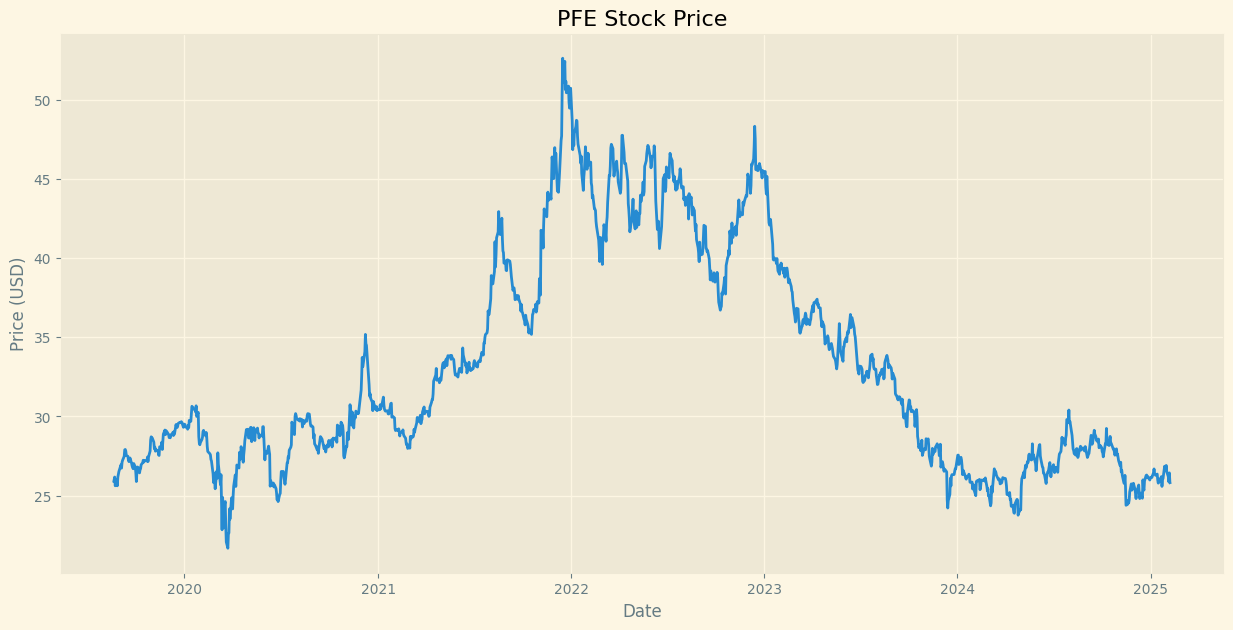

In [19]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
start_date = datetime.now() - timedelta(days=config["data"]["history_days"])
end_date = datetime.now()
symbol = config["data"]["stock_symbol"]
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = df.columns.get_level_values(0)

print("Data shape:", df.shape)
display(df.head())

# Plot closing price
plt.figure(figsize=(15, 7))
plt.plot(df['Close'])
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


In [3]:

df['Returns'] = df['Close'].pct_change()  
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))  

df.fillna(method='ffill', inplace=True)  
df.fillna(method='bfill', inplace=True)  

In [4]:
def plot_distributions(df: pd.DataFrame) -> None:

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Returns Distribution with KDE
    sns.histplot(
        data=df['Returns'].dropna(),
        kde=True,
        stat='density',
        ax=axes[0,0]
    )
    sns.kdeplot(
        data=df['Returns'].dropna(),
        ax=axes[0,0],
        color='red',
        linewidth=2
    )
    axes[0,0].set_title('Returns Distribution with KDE')
    axes[0,0].set_xlabel('Daily Returns')
    axes[0,0].set_ylabel('Density')
    
    # 2. QQ Plot
    stats.probplot(
        df['Returns'].dropna(),
        dist="norm",
        plot=axes[0,1]
    )
    axes[0,1].set_title('Q-Q Plot of Returns')
    
    # 3. Rolling Statistics with confidence intervals
    window = 30  
    rolling_mean = df['Returns'].rolling(window=window).mean()
    rolling_std = df['Returns'].rolling(window=window).std()
    
    axes[1,0].plot(
        rolling_mean,
        label=f'{window}-day MA',
    )
    axes[1,0].plot(
        rolling_std,
        label=f'{window}-day STD',
    )
    axes[1,0].fill_between(
        df.index,
        rolling_mean - 2*rolling_std,
        rolling_mean + 2*rolling_std,
        alpha=0.2
    )
    
    axes[1,0].set_title('Rolling Statistics')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Value')
    axes[1,0].legend()
    

    # 4. Distribution of Return Types
    sns.boxenplot(
    data=df[['Returns', 'Log_Returns']].dropna(),
    ax=axes[1,1]
        )
    axes[1,1].set_title('Distribution of Returns Types')
    axes[1,1].set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    stats_summary = {
        'mean': df['Returns'].mean(),
        'std': df['Returns'].std(),
        'skew': df['Returns'].skew(),
        'kurtosis': df['Returns'].kurtosis()
    }
    
    
    table = Table(title="Distribution Statistics")
    table.add_column("Metric", style="cyan")
    table.add_column("Value", style="magenta")
    
    for metric, value in stats_summary.items():
        table.add_row(metric.title(), f"{value:.6f}")
    
    console.print(table)

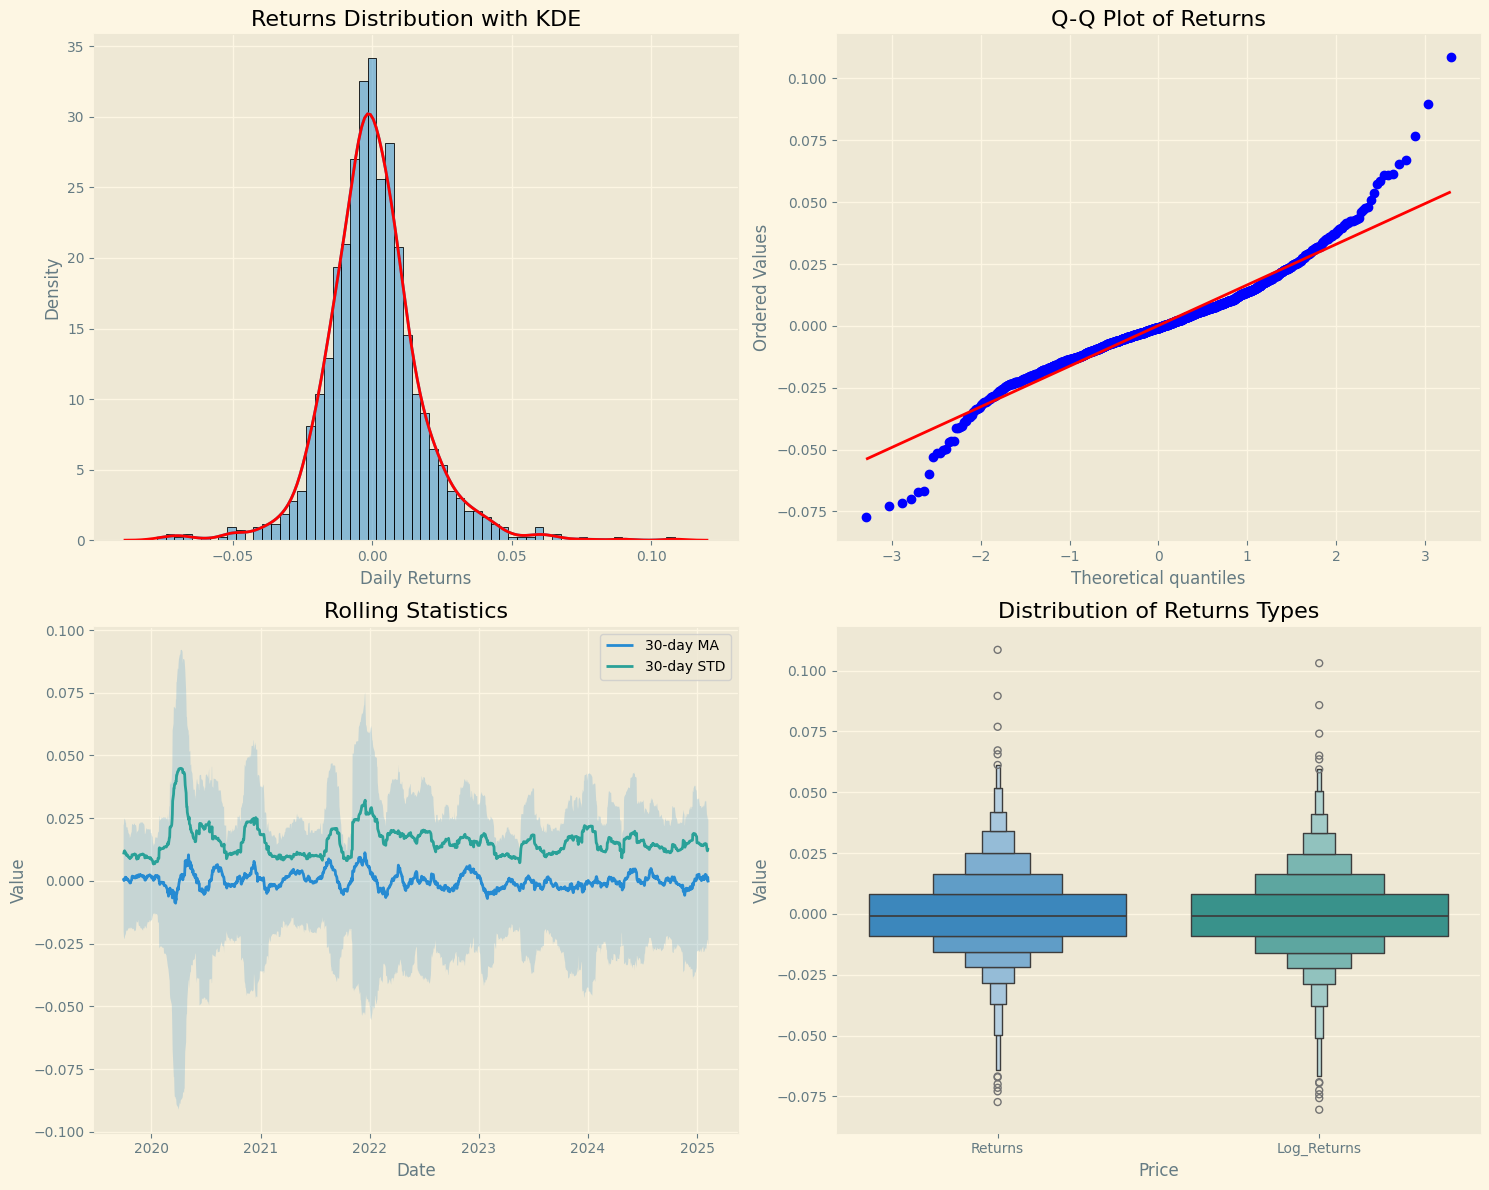

Distribution Statistics
┏━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric   ┃ Value    ┃
┡━━━━━━━━━━╇━━━━━━━━━━┩
│ Mean     │ 0.000144 │
│ Std      │ 0.016833 │
│ Skew     │ 0.358784 │
│ Kurtosis │ 4.075560 │
└──────────┴──────────┘

In [5]:
plot_distributions(df)

In [6]:
def test_stationarity(df: pd.DataFrame) -> None:
    results = {}
    adf_result = adfuller(df['Returns'].dropna())
    results['adf'] = {
        'test_statistic': adf_result[0],
        'p_value': adf_result[1],
        'is_stationary': adf_result[1] < 0.05
    }
    
    kpss_result = kpss(df['Returns'].dropna())
    results['kpss'] = {
        'test_statistic': kpss_result[0],
        'p_value': kpss_result[1],
        'is_stationary': kpss_result[1] > 0.05
    }
    
    table = Table(title="Stationarity Test Results")
    table.add_column("Test", style="cyan")
    table.add_column("Statistic", style="magenta")
    table.add_column("P-Value", style="green")
    table.add_column("Result", style="yellow")
   
    for test_name, test_results in results.items():
        table.add_row(
            test_name.upper(),
            f"{test_results['test_statistic']:.4f}",
            f"{test_results['p_value']:.4f}",
            "✓ Stationary" if test_results['is_stationary'] else "✗ Non-stationary"
        )
    console.print(table)

In [7]:
test_stationarity(df)

          Stationarity Test Results          
┏━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Test ┃ Statistic ┃ P-Value ┃ Result       ┃
┡━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ ADF  │ -8.1840   │ 0.0000  │ ✓ Stationary │
│ KPSS │ 0.2556    │ 0.1000  │ ✓ Stationary │
└──────┴───────────┴─────────┴──────────────┘

In [8]:
def analyze_seasonality(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Monthly seasonality
    monthly_returns = df.groupby([df.index.year, df.index.month])['Returns'].mean().unstack()
    
    sns.heatmap(
        monthly_returns,
        ax=axes[0],
        cmap='RdYlBu_r',
        center=0
    )
    axes[0].set_title('Monthly Returns Heatmap')
    
    # Day of week seasonality
    daily_returns = df.groupby(df.index.dayofweek)['Returns'].mean()
    daily_returns.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Average Returns by Day of Week')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Average Returns')
    
    plt.tight_layout()
    plt.show()


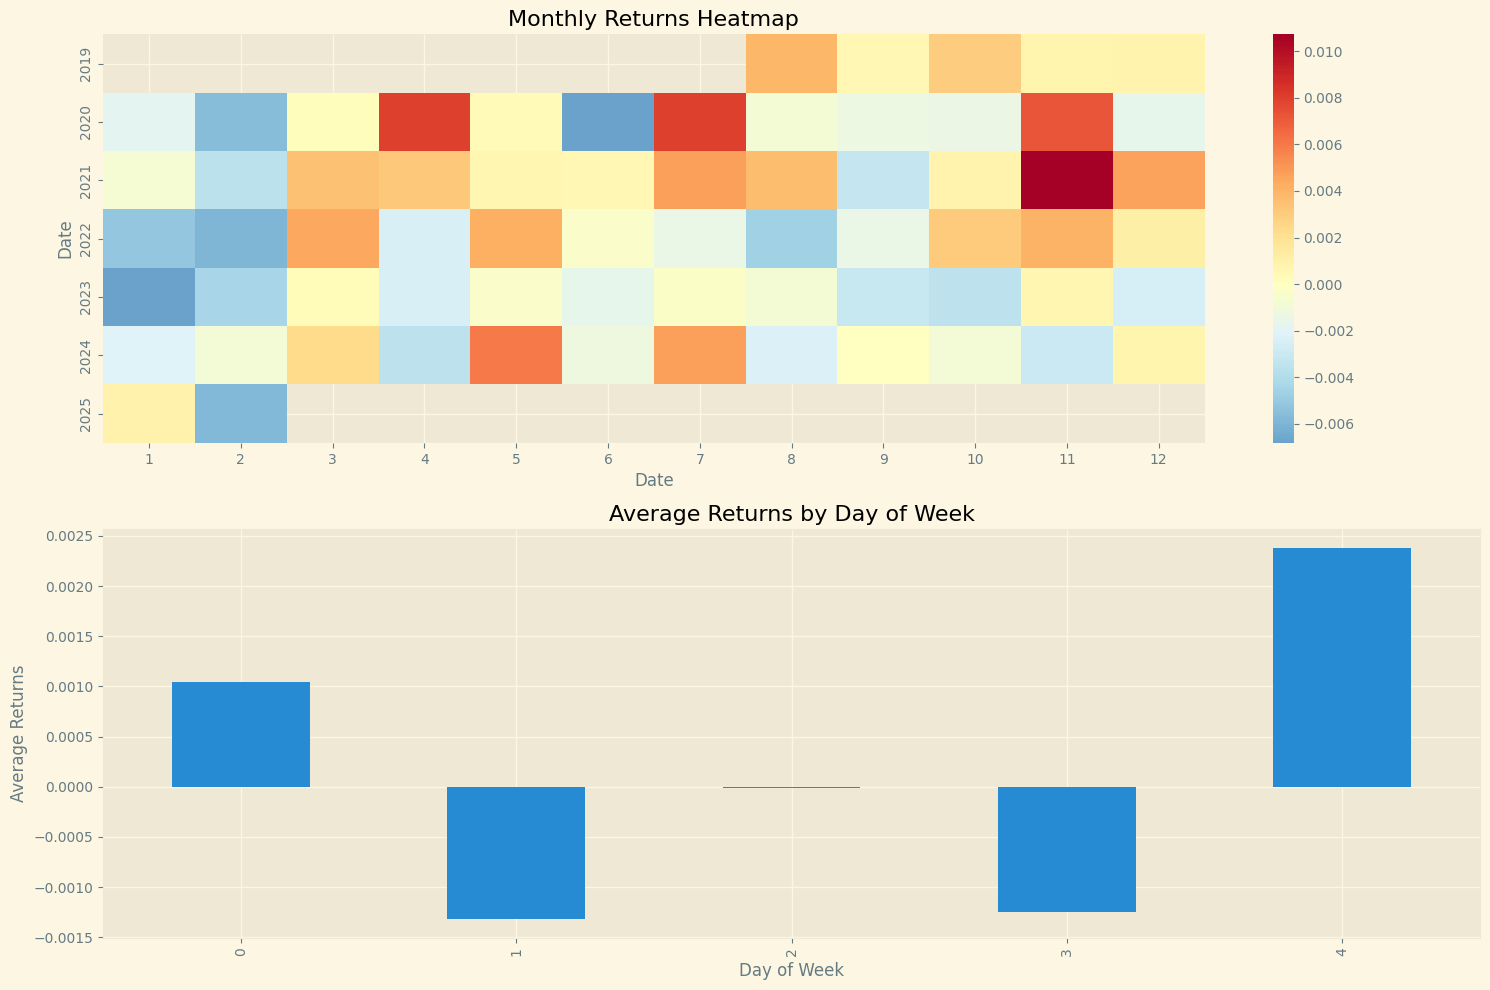

In [9]:
analyze_seasonality(df)

In [10]:
def detect_anomalies(df: pd.DataFrame, n_std: float = 3) -> None:
    z_scores = np.abs(stats.zscore(df['Returns'].dropna()))
    anomalies = z_scores > n_std
    
    # Visualize anomalies
    plt.figure(figsize=(15, 7))
    plt.plot(df['Returns'], label='Returns', alpha=0.5)
    plt.scatter(
        df.index[anomalies],
        df['Returns'][anomalies],
        color='red',
        label=f'Anomalies (>{n_std}σ)'
    )
    plt.title('Significant Price Movements')
    plt.legend()
    plt.show()
    
    # Calculate and print the number of anomalies
    total_anomalies = anomalies.sum()
    positive_anomalies = (df['Returns'][anomalies] > 0).sum()
    negative_anomalies = (df['Returns'][anomalies] < 0).sum()
    
    console.print(f"Total Anomalies: {total_anomalies}")
    console.print(f"Positive Anomalies: {positive_anomalies}")
    console.print(f"Negative Anomalies: {negative_anomalies}")

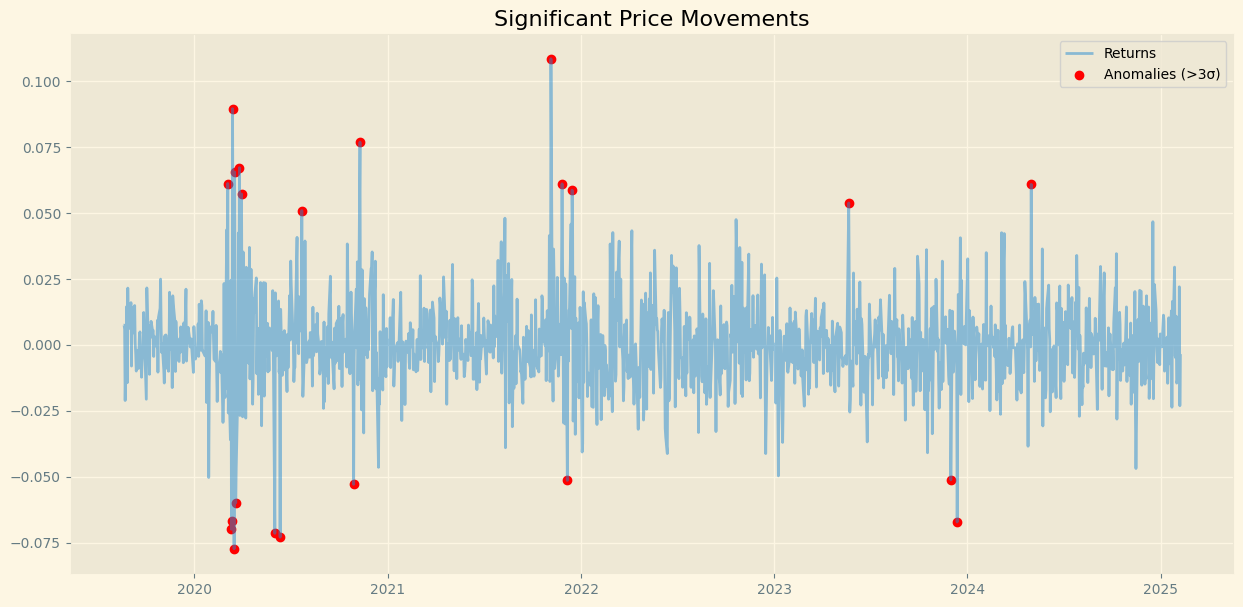

Total Anomalies: 22

Positive Anomalies: 12

Negative Anomalies: 10

In [11]:
detect_anomalies(df)

In [12]:
def analyze_time_series_components(df: pd.DataFrame) -> None:
    # Time series decomposition
    decomposition = seasonal_decompose(
        df['Close'],
        period=21  
    )
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0])
    axes[0].set_title('Observed')
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title('Trend')
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title('Seasonal')
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title('Residual')
    plt.tight_layout()
    plt.show()
    
    lb_test = acorr_ljungbox(df['Returns'].dropna(), lags=[10, 20, 30])
    
    
    table = Table(title="Ljung-Box Test Results")
    table.add_column("Lags", style="cyan")
    table.add_column("Statistic", style="magenta")
    table.add_column("P-Value", style="yellow")
    table.add_column("Interpretation", style="green")
    
    for lag, stat, pval in zip(lb_test.index, lb_test['lb_stat'], lb_test['lb_pvalue']):
        table.add_row(
            str(lag),
            f"{stat:.2f}",
            f"{pval:.4f}"
        )
    
    console.print(table)

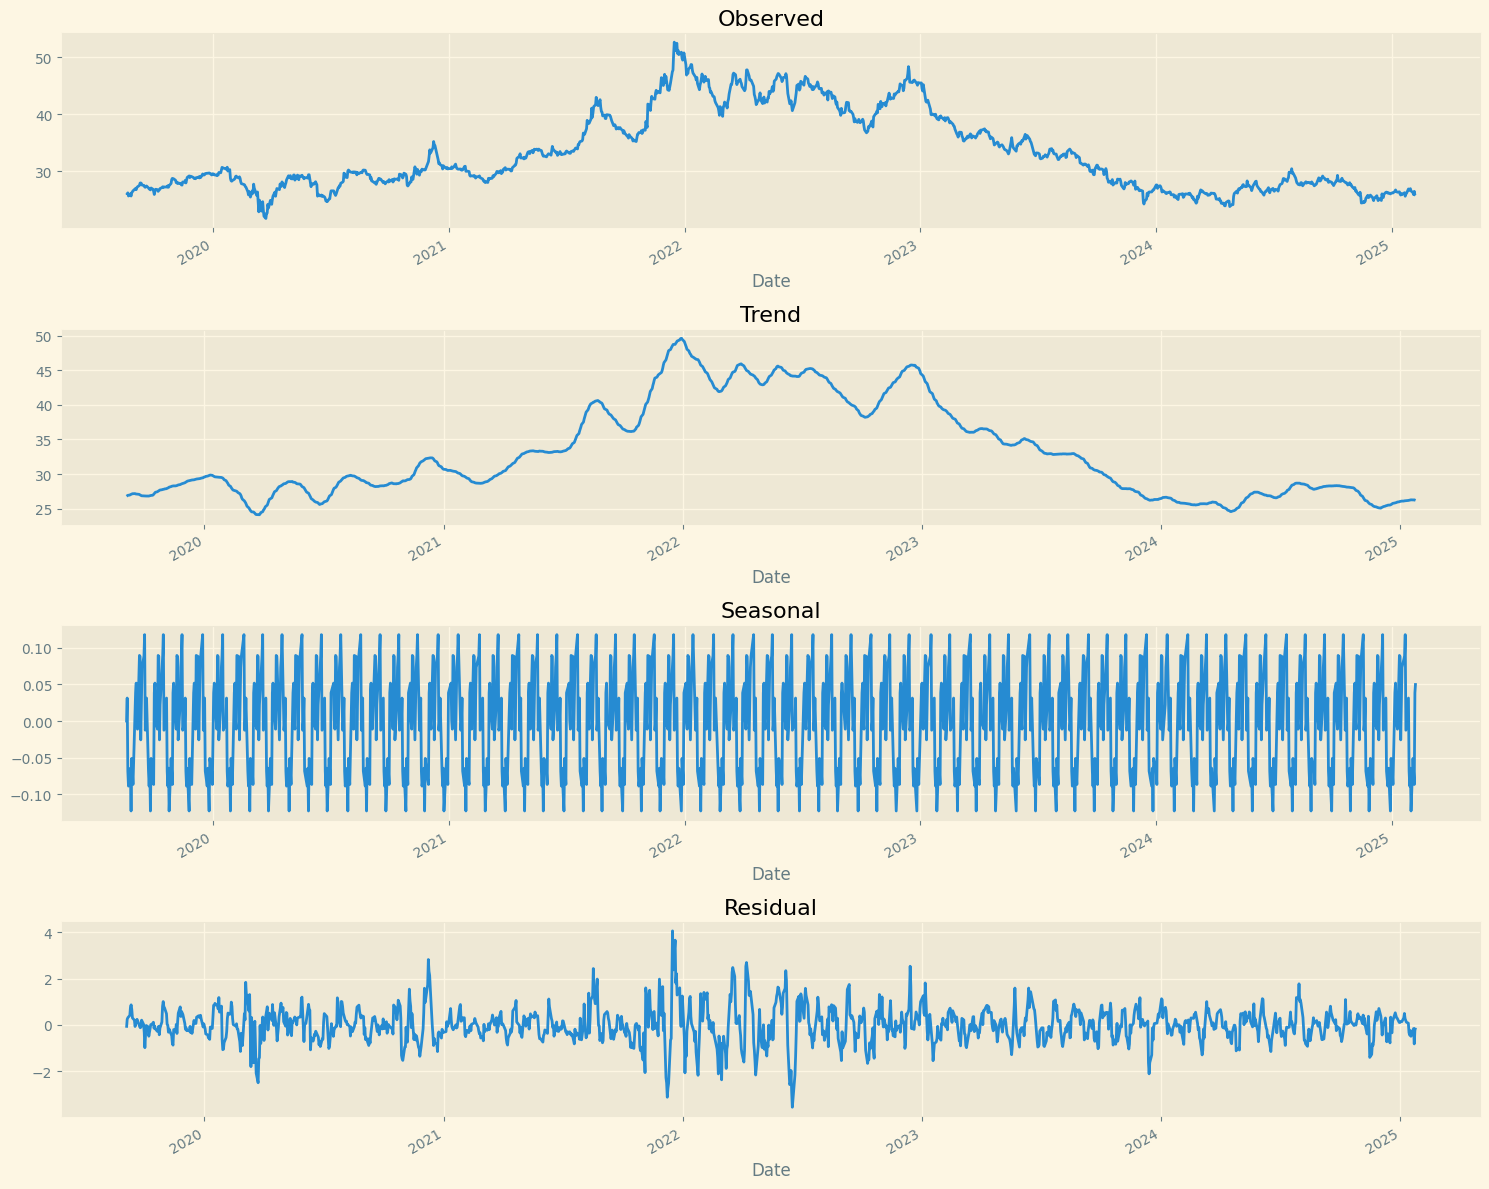

            Ljung-Box Test Results             
┏━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Lags ┃ Statistic ┃ P-Value ┃ Interpretation ┃
┡━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 10   │ 40.43     │ 0.0000  │                │
│ 20   │ 62.88     │ 0.0000  │                │
│ 30   │ 83.57     │ 0.0000  │                │
└──────┴───────────┴─────────┴────────────────┘

In [13]:
analyze_time_series_components(df)

# Modeling

In [14]:
class DataLoader:
    def __init__(self, config: dict):
        self.config = config
        logger.add("logs/data_loader.log", rotation="500 MB", enqueue=True)
        self.logger = logger

    def load_data(self) -> pd.DataFrame:
        start_date = datetime.now() - timedelta(days=self.config["data"]["history_days"])
        end_date = datetime.now()
        symbol = self.config["data"]["stock_symbol"]
        self.logger.info(f"Loading data for {symbol} from {start_date} to {end_date}")
        df = yf.download(symbol, start=start_date, end=end_date)
        df = df.ffill().bfill()
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        df.index.name = "Date"
        
        for lag in [1, 2, 3, 5, 7, 10, 14]:
            df[f"Close_lag_{lag}"] = df["Close"].shift(lag)
        df.dropna(inplace=True)
        self.logger.info(f"Data loaded successfully with shape {df.shape}")
        return df

    def prepare_train_val_test_split(self, df: pd.DataFrame):
        seq_len = self.config["data"]["sequence_length"]
        n = len(df)
        train_idx = int(n * self.config["data"]["train_size"])
        val_idx = train_idx + int(n * self.config["data"]["val_size"])
        train_df = df.iloc[:train_idx].copy()
        val_df = df.iloc[train_idx - seq_len:val_idx].copy()
        test_df = df.iloc[val_idx - seq_len:].copy()
        self.logger.info(f"Data split: Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")
        return train_df, val_df, test_df


In [15]:
class FeatureEngineer:
    def __init__(self, config: dict):
        self.config = config
        self.sequence_length = config["data"]["sequence_length"]
        self.scalers = {}
        self.target_scaler = None
        logger.add("logs/feature_engineering.log", rotation="500 MB", enqueue=True)
        self.logger = logger

    def create_features(self, df: pd.DataFrame, is_training: bool=False) -> pd.DataFrame:
        df = df.copy()
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        if not isinstance(df.index, pd.DatetimeIndex):
            df.set_index("Date", inplace=True)
        
        # Target definition
        df["target"] = df["Close"].shift(-1)
        
        # Technical indicators
        df["rsi"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
        macd = ta.trend.MACD(df["Close"])
        df["macd"] = macd.macd()
        df["macd_signal"] = macd.macd_signal()
        bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
        df["bollinger_high"] = bb.bollinger_hband()
        df["bollinger_low"] = bb.bollinger_lband()
        df["atr"] = ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], window=14).average_true_range()
        df["adx"] = ta.trend.ADXIndicator(df["High"], df["Low"], df["Close"], window=14).adx()
        df["obv"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()
        stoch = ta.momentum.StochasticOscillator(df["High"], df["Low"], df["Close"], window=14, smooth_window=3)
        df["stoch_k"] = stoch.stoch()
        df["stoch_d"] = stoch.stoch_signal()
        acc_dist = ta.volume.AccDistIndexIndicator(df["High"], df["Low"], df["Close"], df["Volume"]).acc_dist_index()
        df["acc_dist"] = acc_dist
        df["mfi"] = ta.volume.MFIIndicator(high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"]).money_flow_index()
        df["cci"] = ta.trend.CCIIndicator(high=df["High"], low=df["Low"], close=df["Close"], window=20).cci()
        
        # Volume trend: volume momentum relative to 20-day MA
        df["vol_ma_20"] = df["Volume"].rolling(window=20).mean()
        df["vol_mom"] = df["Volume"] / df["vol_ma_20"] - 1
        
        eps = yf.Ticker(symbol).info.get("trailingEps", np.nan)
        div_yield = yf.Ticker(symbol).info.get("dividendYield", np.nan)
        df["eps"] = eps
        df["dividend_yield"] = div_yield
        
        df.dropna(inplace=True)
        
        if is_training:
            self._fit_scalers(df)
        df = self._scale_features(df)
        self.logger.info(f"Feature engineering complete. New shape: {df.shape}")
        return df

    def _fit_scalers(self, df: pd.DataFrame):
        for col in df.columns:
            if col != "target":
                scaler = RobustScaler()
                scaler.fit(df[[col]])
                self.scalers[col] = scaler
        self.target_scaler = RobustScaler()
        self.target_scaler.fit(df[["target"]])
        
    def _scale_features(self, df: pd.DataFrame) -> pd.DataFrame:
        for col, scaler in self.scalers.items():
            df[col] = scaler.transform(df[[col]])
        if self.target_scaler is not None:
            df["target"] = self.target_scaler.transform(df[["target"]].values)
        return df

    def create_sequences(self, df: pd.DataFrame):
        X, y = [], []
        features = [col for col in df.columns if col != "target"]
        for i in range(len(df) - self.sequence_length):
            seq = df[features].iloc[i: i + self.sequence_length].values
            target_value = df["target"].iloc[i + self.sequence_length]
            X.append(seq)
            y.append(target_value)
        self.logger.info(f"Generated {len(X)} sequences from data shape {df.shape}")
        return np.array(X), np.array(y)
    
    def perform_rfe(self, X_df: pd.DataFrame, y, essential_features, n_features_to_select=12):
        model = RandomForestRegressor(n_estimators=50, random_state=42)
        rfe = RFE(model, n_features_to_select=n_features_to_select, step=1)
        rfe.fit(X_df, y)
        selected = X_df.columns[rfe.support_].tolist()
        for feat in essential_features:
            if feat not in selected:
                selected.append(feat)
        return selected, rfe.ranking_

In [16]:
class LSTMModel:
    def __init__(self, config: dict):
        self.config = config
        self.model = None
        logger.add("logs/model.log", rotation="500 MB", enqueue=True)
        self.logger = logger

    def build_model(self, input_shape: tuple) -> Model:
        inputs = Input(shape=input_shape)
        x = LSTM(64, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
        outputs = Dense(1, activation="linear")(x)
        self.model = Model(inputs, outputs)
        optimizer = Adam(learning_rate=self.config["model"]["training"]["learning_rate"])
        self.model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
        self.logger.info("LSTM model built successfully.")
        return self.model

    def train(self, train_data: tuple, val_data: tuple = None) -> dict:
        callbacks = [
            EarlyStopping(monitor="val_loss", patience=self.config["model"]["training"]["early_stopping"]["patience"],
                          restore_best_weights=True, verbose=0),
            ModelCheckpoint("models/best_model.keras", monitor="val_loss", save_best_only=True, verbose=0)
        ]
        history = self.model.fit(
            train_data[0], train_data[1],
            validation_data=val_data,
            epochs=self.config["model"]["training"]["epochs"],
            batch_size=self.config["model"]["training"]["batch_size"],
            callbacks=callbacks,
            shuffle=False,
            verbose=0
        )
        self.logger.info("Training complete.")
        return history.history

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray, target_scaler) -> dict:
        preds = self.model.predict(X_test, verbose=0)
        y_pred = target_scaler.inverse_transform(preds.reshape(-1, 1))
        y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        metrics = {
            "MAE": mean_absolute_error(y_true, y_pred),
            "MSE": mean_squared_error(y_true, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "R2": r2_score(y_true, y_pred)
        }
        self.logger.info(f"Evaluation metrics: {metrics}")
        return metrics

    def time_series_cv_evaluation(self, X, y, target_scaler, n_splits=3):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        metrics_list = []
        fold = 1
        for train_idx, val_idx in tscv.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            model_instance = LSTMModel(self.config)
            model_instance.build_model(input_shape=X_tr.shape[1:])
            history = model_instance.train((X_tr, y_tr), (X_val, y_val))
            m = model_instance.evaluate(X_val, y_val, target_scaler)
            metrics_list.append(m)
            if fold == 1:
                plt.figure(figsize=(8, 4))
                plt.plot(history['loss'], label="Train Loss")
                plt.plot(history['val_loss'], label="Validation Loss")
                plt.title("Learning Curve - Fold 1")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()
                plt.savefig("results/learning_curve_fold1.png")
                plt.close()
            fold += 1
        avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0]}
        print("TimeSeries CV Average Metrics:", avg_metrics)
        return avg_metrics

In [17]:
def run_training_pipeline(config_path: str):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate loader and feature engineer
    data_loader = DataLoader(config)
    feature_engineer = FeatureEngineer(config)

    df = data_loader.load_data()
    train_df, val_df, test_df = data_loader.prepare_train_val_test_split(df)
    
    # Create features for each split
    train_features = feature_engineer.create_features(train_df, is_training=True)
    val_features = feature_engineer.create_features(val_df, is_training=False)
    test_features = feature_engineer.create_features(test_df, is_training=False)
    
    # Perform RFE on training features
    X_train_df = train_features.drop("target", axis=1)
    y_train = train_features["target"]
    essential_features = ["Close_lag_1", "eps", "dividend_yield", "rsi", "macd", "vol_mom"]
    selected_feats, rankings = feature_engineer.perform_rfe(X_train_df, y_train, essential_features, n_features_to_select=12)
    print("Selected features after RFE:", selected_feats)
    
    # Keep only the selected features and target for all splits
    cols_to_keep = selected_feats + ["target"]
    train_features = train_features[cols_to_keep].copy()
    val_features = val_features[cols_to_keep].copy()
    test_features = test_features[cols_to_keep].copy()
    
    # Create sequences for modeling
    X_train, y_train = feature_engineer.create_sequences(train_features)
    X_val, y_val = feature_engineer.create_sequences(val_features)
    X_test, y_test = feature_engineer.create_sequences(test_features)
    
    input_shape = (config["data"]["sequence_length"], X_train.shape[2])
    
    # TimeSeries CV evaluation (n_splits=3)
    model_instance = LSTMModel(config)
    cv_metrics = model_instance.time_series_cv_evaluation(X_train, y_train, feature_engineer.target_scaler, n_splits=3)
    print("CV Metrics:", cv_metrics)
    
    # Build, train, and evaluate final model on test set
    final_model = LSTMModel(config)
    final_model.build_model(input_shape)
    final_model.train((X_train, y_train), (X_val, y_val))
    test_metrics = final_model.evaluate(X_test, y_test, target_scaler=feature_engineer.target_scaler)
    
    print("Final Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Save predicted vs. actual plot in results folder
    preds = final_model.model.predict(X_test, verbose=0)
    y_pred = feature_engineer.target_scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = feature_engineer.target_scaler.inverse_transform(y_test.reshape(-1, 1))
    plt.figure(figsize=(8, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title("Test Set: Actual vs Predicted")
    plt.xlabel("Sample")
    plt.ylabel("Price")
    plt.legend()
    plt.savefig("results/test_predictions.png")
    plt.close()
    
    return final_model, cv_metrics, test_metrics

In [18]:
run_training_pipeline("../config.yaml")

2025-02-08 21:01:22.423 | INFO     | __main__:load_data:11 - Loading data for PFE from 2019-08-19 21:01:22.423027 to 2025-02-08 21:01:22.423058
[*********************100%***********************]  1 of 1 completed
2025-02-08 21:01:29.727 | INFO     | __main__:load_data:21 - Data loaded successfully with shape (1362, 12)
2025-02-08 21:01:29.733 | INFO     | __main__:prepare_train_val_test_split:32 - Data split: Train 817, Val 332, Test 333
2025-02-08 21:01:31.544 | INFO     | __main__:create_features:60 - Feature engineering complete. New shape: (783, 18)
2025-02-08 21:01:31.948 | INFO     | __main__:create_features:60 - Feature engineering complete. New shape: (298, 18)
2025-02-08 21:01:32.566 | INFO     | __main__:create_features:60 - Feature engineering complete. New shape: (299, 18)


Selected features after RFE: ['Close_lag_1', 'rsi', 'macd', 'bollinger_high', 'bollinger_low', 'atr', 'adx', 'obv', 'stoch_k', 'acc_dist', 'mfi', 'vol_mom', 'eps', 'dividend_yield']


2025-02-08 21:01:38.856 | INFO     | __main__:create_sequences:87 - Generated 723 sequences from data shape (783, 15)
2025-02-08 21:01:39.124 | INFO     | __main__:create_sequences:87 - Generated 238 sequences from data shape (298, 15)
2025-02-08 21:01:39.351 | INFO     | __main__:create_sequences:87 - Generated 239 sequences from data shape (299, 15)
2025-02-08 21:01:39.696 | INFO     | __main__:build_model:15 - LSTM model built successfully.
2025-02-08 21:02:05.765 | INFO     | __main__:train:33 - Training complete.
2025-02-08 21:02:06.701 | INFO     | __main__:evaluate:46 - Evaluation metrics: {'MAE': 2.0977608362833657, 'MSE': 5.863973539389513, 'RMSE': 2.4215642752959323, 'R2': -0.6787267332831806}
2025-02-08 21:02:07.145 | INFO     | __main__:build_model:15 - LSTM model built successfully.
2025-02-08 21:02:26.012 | INFO     | __main__:train:33 - Training complete.
2025-02-08 21:02:26.804 | INFO     | __main__:evaluate:46 - Evaluation metrics: {'MAE': 8.213911385006375, 'MSE': 92.

2025-02-08 21:02:54.782 | INFO     | __main__:evaluate:46 - Evaluation metrics: {'MAE': 1.0620564142862956, 'MSE': 1.8510389893416788, 'RMSE': 1.3605289373407972, 'R2': 0.7229603453260041}


TimeSeries CV Average Metrics: {'MAE': 3.7912428785253454, 'MSE': 33.26873058912146, 'RMSE': 4.459502709521364, 'R2': -0.9558321292347998}
CV Metrics: {'MAE': 3.7912428785253454, 'MSE': 33.26873058912146, 'RMSE': 4.459502709521364, 'R2': -0.9558321292347998}


2025-02-08 21:02:55.083 | INFO     | __main__:build_model:15 - LSTM model built successfully.
2025-02-08 21:03:56.158 | INFO     | __main__:train:33 - Training complete.


2025-02-08 21:03:57.100 | INFO     | __main__:evaluate:46 - Evaluation metrics: {'MAE': 0.9941338495230575, 'MSE': 1.3318312813554947, 'RMSE': 1.1540499475133192, 'R2': 0.2832681226184727}


Final Test Metrics:
MAE: 0.9941
MSE: 1.3318
RMSE: 1.1540
R2: 0.2833


(<__main__.LSTMModel at 0x1678ddf60>,
 {'MAE': 3.7912428785253454,
  'MSE': 33.26873058912146,
  'RMSE': 4.459502709521364,
  'R2': -0.9558321292347998},
 {'MAE': 0.9941338495230575,
  'MSE': 1.3318312813554947,
  'RMSE': 1.1540499475133192,
  'R2': 0.2832681226184727})